# Maximum Likelihood Estimation of a multivariate Gaussian model

The goal of this notebook is to use PyTorch to implement Gradient-based MLE for a multivariate Gaussian model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Single 2D Gaussian component

Let's generate a some data by sampling a multivariate Gaussian with an arbitrary covariance matrix:

In [2]:
rng = np.random.RandomState(42)
n_features = 2

mean = rng.randn(n_features)
mean

array([ 0.49671415, -0.1382643 ])

In [3]:
h = rng.randn(n_features, n_features)
Cov = h @ h.T
Cov

array([[ 2.73912039, -0.50825603],
       [-0.50825603,  0.10964792]])

In [4]:
np.linalg.cholesky(np.linalg.inv(Cov))

array([[ 1.61547341,  0.        ],
       [ 7.48827815,  3.01995037]])

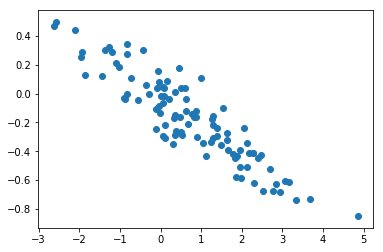

In [5]:
n_samples = 100
data = rng.multivariate_normal(mean, Cov, size=n_samples)
plt.scatter(data[:, 0], data[:, 1]);

Let's compute the MLE estimate from this data using the closed-form formula:

In [6]:
mu_mle = data.mean(axis=0)
mu_mle

array([ 0.70263098, -0.17305392])

In [7]:
Cov_mle = (data - mu_mle).T @ (data - mu_mle) / n_samples
Cov_mle

array([[ 2.0476404 , -0.38824024],
       [-0.38824024,  0.08873728]])

In [8]:
np.linalg.cholesky(np.linalg.inv(Cov_mle))

array([[ 1.69266713,  0.        ],
       [ 7.40569797,  3.356966  ]])

## Parametrisation of a positive definite matrix


Let's parametrize the precision matrix `P` (inverse of a covariance matrix `C`) as follows:

- `P` has Cholesky decomposition `H`
- `H` is a lower triangular with a positive diagonal
- the log of the diagonal entry is stored in a vector of parameters named `d`
- the off diagonal elements of `H` are stored in the matrix of parameters named `W`

In [9]:
import torch
from torch.autograd import Variable

mu = Variable(torch.zeros(n_features), requires_grad=True)
d = Variable(torch.ones(n_features), requires_grad=True)
W = Variable(torch.randn(n_features, n_features), requires_grad=True)
H = torch.diag(torch.exp(d)) + torch.tril(W, -1)
P = H @ H.transpose(1, 0)
P

Variable containing:
 7.3891 -1.4755
-1.4755  7.6837
[torch.FloatTensor of size 2x2]

Let's check that H is the actual Cholesky decomposition of P:

In [10]:
H.data.numpy()

array([[ 2.71828175,  0.        ],
       [-0.54281157,  2.71828175]], dtype=float32)

In [11]:
np.linalg.cholesky(P.data.numpy())

array([[ 2.71828175,  0.        ],
       [-0.54281157,  2.71828175]], dtype=float32)

`P` is positive semi-definite by construction (product of a matrix `H` by its transposed).

Because of we take the `exp` of `d` to build the diagonal elements of `H`, the determinant of `H` and therefore `P` is stricly positive.

`P` is therefore is positive definite, whatever the values the parameters in `d` and `W`. Because the Cholesky decomposition exists for any symmetric positive-definite  matrix and is unique and `exp` is a bijection from $\mathbb{R}$ to $\mathbb{R}^+$, this parametrization of the manifold of positive definite matrices is bijective.

In [12]:
np.linalg.det(P.data.numpy())

54.598145

In [13]:
np.linalg.det(H.data.numpy()) ** 2

54.598144564972472

The determinant of `P` is cheap to compute from the `d` parameters directly:

In [14]:
torch.prod(torch.exp(d.data) ** 2)

54.59814456497247

Let's use the above function to define the log-likelihood of a Gaussian model:

In [15]:
from math import log


def loglik(X, mu, d, W):
    """Compute the average log-likelihood of samples
    
    X shape: (n_samples, n_features)
        data points
        
    mu: shape: (n_features,)
        parameters of the mean of the Gaussian.
    
    d: shape: (n_features,)
        parameters of the diagonal of the Cholesky factor of the
        precision matrix of the Gaussian.
        
    W: shape: (n_features, n_features)
        parameters of the off-diagonal of the Cholesky factor of the
        precision matrix of the Gaussian. The upper-diagonal elements
        are ignored.
    """
    H = torch.diag(torch.exp(d)) + torch.tril(W, -1)
    P = H @ H.transpose(1, 0)
    diff = X - mu
    quad_form = torch.sum(diff * (diff @ P), dim=1)
    return (-0.5 * log(2 * np.pi) + torch.sum(d) - 0.5 * quad_form)


def nll(X, mu, d, W):
    """Average negative log likelihood loss to minimize"""
    return -torch.mean(loglik(X, mu, d, W))

In [16]:
X = Variable(torch.FloatTensor(data))
loss = nll(X, mu, d, W)
loss

Variable containing:
 9.5162
[torch.FloatTensor of size 1]

In [17]:
loss.backward([torch.ones(1)])

In [18]:
mu.grad

Variable containing:
-5.4471
 2.3664
[torch.FloatTensor of size 2]

In [19]:
d.grad

Variable containing:
 18.5303
 -0.1230
[torch.FloatTensor of size 2]

In [20]:
W.grad

Variable containing:
 0.0000  0.0000
-1.4503  0.0000
[torch.FloatTensor of size 2x2]

In [21]:
H_mle = torch.FloatTensor(np.linalg.cholesky(np.linalg.inv(Cov_mle)))
d_mle = Variable(torch.log(torch.diag(H_mle)))
W_mle = Variable(torch.tril(H_mle, -1))
nll(X, Variable(torch.FloatTensor(mu_mle)), d_mle, W_mle)

Variable containing:
 0.1816
[torch.FloatTensor of size 1]

In [22]:
learning_rate = 1e-1
optimizer = torch.optim.Adam([mu, d, W], lr=learning_rate)
for t in range(2000):
    # Compute and print loss.
    loss = nll(X, mu, d, W)
    if t % 100 == 0:
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 9.516191482543945
100 0.36440008878707886
200 0.19654464721679688
300 0.1821846216917038
400 0.18160586059093475
500 0.18159542977809906
600 0.18159565329551697
700 0.18161100149154663
800 0.18159569799900055
900 0.18159551918506622
1000 0.18159547448158264
1100 0.18226905167102814
1200 0.18159545958042145
1300 0.1815958023071289
1400 0.18162307143211365
1500 0.18159577250480652
1600 0.1815953552722931
1700 0.18165569007396698
1800 0.18159538507461548
1900 0.18159548938274384


In [23]:
mu_mle

array([ 0.70263098, -0.17305392])

In [24]:
mu

Variable containing:
 0.7028
-0.1725
[torch.FloatTensor of size 2]

In [25]:
d_mle

Variable containing:
 0.5263
 1.2110
[torch.FloatTensor of size 2]

In [26]:
d

Variable containing:
 0.5263
 1.2110
[torch.FloatTensor of size 2]

In [27]:
W * Variable(torch.tril(torch.ones(n_features, n_features), -1))

Variable containing:
-0.0000  0.0000
 7.4055 -0.0000
[torch.FloatTensor of size 2x2]

In [28]:
W_mle

Variable containing:
 0.0000  0.0000
 7.4057  0.0000
[torch.FloatTensor of size 2x2]

## Mixture of 2D Gaussian components

Let's generate some ground truth Gaussian Mixture Model with 3 components.

In [29]:
rng = np.random.RandomState(42)
n_features = 2
n_components = 3

true_means = [rng.randn(n_features) * 3 for _ in range(n_components)]
true_means

[array([ 1.49014246, -0.4147929 ]),
 array([ 1.94306561,  4.56908957]),
 array([-0.70246012, -0.70241087])]

In [30]:
true_covariances = []
for _ in range(n_components):
    h = rng.randn(n_features, n_features)
    true_covariances.append(h @ h.T)

Let's generate some data from the ground truth model:

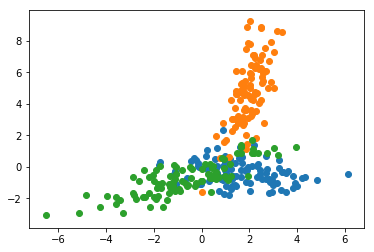

In [31]:
from sklearn.utils import shuffle

n_samples_per_component = 100

samples = []
component_ids = []

for i, mean, Cov in zip(range(n_components), true_means, true_covariances):
    data = rng.multivariate_normal(mean, Cov, size=n_samples_per_component)
    samples.append(data)
    component_ids.append(i * np.ones(n_samples_per_component, dtype=np.int32))
    plt.scatter(data[:, 0], data[:, 1])
    
data = np.vstack(samples)
component_ids = np.concatenate(component_ids)

data, component_ids = shuffle(data, component_ids, random_state=0)

There is no closed form formula for the MLE. Let's use the scikit-learn implementation of the EM algorithm instead:

In [32]:
from sklearn.mixture import GaussianMixture


gmm_em = GaussianMixture(n_components=3, random_state=0).fit(data)

Average loglikelihood of the data under the EM-MLE model (higher is better):

In [33]:
gmm_em.score(data)

-3.6213242571063557

In [34]:
gmm_em.means_

array([[-0.60843729, -0.7027044 ],
       [ 1.94313479,  4.48270848],
       [ 1.51596953, -0.53611044]])

In [35]:
true_means

[array([ 1.49014246, -0.4147929 ]),
 array([ 1.94306561,  4.56908957]),
 array([-0.70246012, -0.70241087])]

In [36]:
gmm_em.weights_

array([ 0.32384082,  0.35908973,  0.31706944])

In [37]:
gmm_em.covariances_

array([[[ 3.7638645 ,  1.71761884],
        [ 1.71761884,  1.15973123]],

       [[ 0.30253199,  0.76447466],
        [ 0.76447466,  4.88339622]],

       [[ 2.72596464, -0.17407796],
        [-0.17407796,  0.37998651]]])

In [38]:
np.asarray(true_covariances)

array([[[ 3.08286918, -0.32502055],
        [-0.32502055,  0.5147776 ]],

       [[ 0.43166016,  0.77894194],
        [ 0.77894194,  3.71918704]],

       [[ 3.29150879,  1.5703531 ],
        [ 1.5703531 ,  1.12457826]]])

Let's find the MLE by gradient descent. First we need a helper function to compute the log of the sum of likelihoods of the components in a numerically stable way:

In [39]:
def logsumexp(data, dim=0):
    """Numerically stable log sum exp"""
    max_score, _ = torch.max(data, dim)
    if dim == 0:
        max_score_bcast = max_score
    elif dim == 1:
        max_score_bcast = max_score.view(-1, 1)
    else:
        raise NotImplemented("logsumexp with dim=%d is not supported" % dim)
    return max_score + torch.log(torch.sum(torch.exp(data - max_score_bcast), dim))


test_data = torch.randn(3, 4)
logsumexp(test_data, 0)


 0.6123
 1.8312
 1.1842
 0.6889
[torch.FloatTensor of size 4]

In [40]:
torch.log(torch.sum(torch.exp(test_data), 0))


 0.6123
 1.8312
 1.1842
 0.6889
[torch.FloatTensor of size 4]

In [41]:
X = Variable(torch.FloatTensor(data))


logsotfmax = torch.nn.LogSoftmax()
weights = Variable(torch.ones(1, n_components), requires_grad=True)

means = []
prec_diags = []
prec_off_diags = []
for i in range(n_components):
    mu = Variable(torch.randn(n_features), requires_grad=True)
    means.append(mu)
    d = Variable(torch.ones(n_features), requires_grad=True)
    prec_diags.append(d)
    W = Variable(torch.randn(n_features, n_features), requires_grad=True)
    prec_off_diags.append(W)


def mixture_nll(X, weights, means, prec_diags, prec_off_diags):
    log_normalized_weights = logsotfmax(weights).transpose(1, 0)
    logliks = []
    for mu, d, W in zip(means, prec_diags, prec_off_diags):
        logliks.append(loglik(X, mu, d, W))
    
    logliks = torch.cat(logliks).view(n_components, -1)
    return torch.mean(-logsumexp(logliks + log_normalized_weights, dim=0))

In [42]:
mixture_nll(X, weights, means, prec_diags, prec_off_diags)

Variable containing:
 42.4368
[torch.FloatTensor of size 1]

In [43]:
params = [weights]
params.extend(means)
params.extend(prec_diags)
params.extend(prec_off_diags)

In [44]:
weights

Variable containing:
 1  1  1
[torch.FloatTensor of size 1x3]

In [45]:
learning_rate = 0.05
optimizer = torch.optim.Adam(params, lr=learning_rate)
best_loss = np.inf
for t in range(5000):
    loss = mixture_nll(X, weights, means, prec_diags, prec_off_diags)
    if t % 100 == 0:
        print(t, loss.data[0])
    if loss.data.numpy() < best_loss:
        best_loss = loss.data.numpy()
    else:
        print(t, loss.data[0], 'converged!')
        break
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 42.43677520751953
100 3.063232660293579
200 2.824497938156128
300 2.7710728645324707
400 2.750455141067505
500 2.7379977703094482
600 2.7285289764404297
700 2.720960855484009
800 2.7149853706359863
900 2.7103676795959473
1000 2.706846237182617
1100 2.7041540145874023
1200 2.7020885944366455
1300 2.7006301879882812
1400 2.6996991634368896
1500 2.699103593826294
1600 2.6987264156341553
1700 2.698498487472534
1800 2.6983683109283447
1900 2.698298931121826
1982 2.6982688903808594 converged!


In [46]:
[m.data.numpy() for m in means]

[array([ 1.94653308,  4.54145813], dtype=float32),
 array([-0.34557292, -0.51862174], dtype=float32),
 array([ 2.11376023, -0.76199687], dtype=float32)]

In [47]:
gmm_em.means_

array([[-0.60843729, -0.7027044 ],
       [ 1.94313479,  4.48270848],
       [ 1.51596953, -0.53611044]])

In [48]:
true_means

[array([ 1.49014246, -0.4147929 ]),
 array([ 1.94306561,  4.56908957]),
 array([-0.70246012, -0.70241087])]

In [49]:
softmax = torch.nn.Softmax()
softmax(weights).view(-1).data.numpy()

array([ 0.3512145 ,  0.43690208,  0.21188341], dtype=float32)

In [50]:
gmm_em.weights_

array([ 0.32384082,  0.35908973,  0.31706944])